In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd
import matplotlib.pyplot as plt
import time
import numpy as np
import urllib.request
import re
import os
import codecs
import numpy as np
from collections import defaultdict
import pickle

In [2]:
# Define constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

def zero_digits(s):
    """
    Replace all digits in the string with 0
    """
    return re.sub(r'\d', '0', s)

def load_sentences(path, zeros=True):
    """
    Load sentences. Each line should contain a word and its label.
    Sentences are separated by blank lines.
    Handle lines that may contain only one token.
    """
    sentences = []
    sentence = []
    
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            # Handle lines with only one token
            if len(word) == 1:
                print(f"Warning: Found a line with only one token: {line}, it will be skipped")
                continue
            # Ensure at least two tokens
            assert len(word) >= 2, f"Format error: {line}"
            sentence.append(word)
    
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    
    return sentences

def iob2(tags):
    """
    Check if tags are in valid BIO format.
    Convert BIO1 format tags to BIO2 format.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # Convert IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # Convert IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    """
    Convert BIO tagging scheme to BIOES tagging scheme
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme='BIOES'):
    """
    Check and update the tagging scheme of sentences to BIOES
    """
    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check if tags are in BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                           f'Please check sentence {i}:\n{s_str}')
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            raise Exception('Invalid tagging scheme!')

def create_dico(item_list):
    """
    Create a dictionary from a list of items, counting frequencies
    """
    assert isinstance(item_list, list)
    dico = defaultdict(int)
    for items in item_list:
        for item in items:
            dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create mappings (item to ID / ID to item) from a dictionary
    Items are sorted by frequency in descending order
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower=True):
    """
    Create a dictionary and mapping for words, sorted by frequency
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000  # Unknown word token
    word_to_id, id_to_word = create_mapping(dico)
    print(f"Found {len(dico)} unique words (total {sum(len(x) for x in words)} words)")
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping for characters, sorted by frequency
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print(f"Found {len(dico)} unique characters")
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and mapping for tags, sorted by frequency
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print(f"Found {len(dico)} unique named entity tags")
    return dico, tag_to_id, id_to_tag

def lower_case(x, lower=False):
    """
    Convert text to lowercase based on the parameter
    """
    if lower:
        return x.lower()  
    else:
        return x

def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Returns a list of dictionaries containing:
        - Word indices
        - Word character indices
        - Tag indices
    """
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[lower_case(w, lower) if lower_case(w, lower) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'tags': tags,
        })
    return data

def load_word_embedding(embedding_path, word_to_id, word_dim=100):
    """
    Load pre-trained word embeddings
    """
    all_word_embeds = {}
    for i, line in enumerate(codecs.open(embedding_path, 'r', 'utf-8')):
        s = line.strip().split()
        if len(s) == word_dim + 1:
            all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

    # Initialize word embedding matrix
    word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), word_dim))

    for w in word_to_id:
        if w in all_word_embeds:
            word_embeds[word_to_id[w]] = all_word_embeds[w]
        elif w.lower() in all_word_embeds:
            word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

    print(f'Loaded {len(all_word_embeds)} pre-trained word embeddings')
    return word_embeds

def preprocess_data(train_path, val_path, test_path, output_path, embedding_path=None, 
                    word_dim=100, tag_scheme='BIOES', lower=True, zeros=True):
    """
    Main preprocessing function that combines all steps
    """
    # Load data
    train_sentences = load_sentences(train_path, zeros)
    val_sentences = load_sentences(val_path, zeros)
    test_sentences = load_sentences(test_path, zeros)
    
    # Update tagging scheme
    update_tag_scheme(train_sentences, tag_scheme)
    update_tag_scheme(val_sentences, tag_scheme)
    update_tag_scheme(test_sentences, tag_scheme)
    
    # Create mappings
    dico_words, word_to_id, id_to_word = word_mapping(train_sentences, lower)
    dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
    dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)
    
    # Prepare final datasets
    train_data = prepare_dataset(train_sentences, word_to_id, char_to_id, tag_to_id, lower)
    val_data = prepare_dataset(val_sentences, word_to_id, char_to_id, tag_to_id, lower)
    test_data = prepare_dataset(test_sentences, word_to_id, char_to_id, tag_to_id, lower)
    
    print(f"{len(train_data)} / {len(val_data)} / {len(test_data)} sentences in train / dev / test sets")
    
    # Load word embeddings (if path is provided)
    word_embeds = None
    if embedding_path:
        word_embeds = load_word_embedding(embedding_path, word_to_id, word_dim)
    
    # Save processed data
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        mappings = {
            'word_to_id': word_to_id,
            'tag_to_id': tag_to_id,
            'char_to_id': char_to_id,
            'train_data': train_data,
            'val_data': val_data,
            'test_data': test_data,
            'word_embeds': word_embeds,
            'id_to_word': id_to_word,
            'id_to_tag': id_to_tag,
            'id_to_char': id_to_char
        }
        pickle.dump(mappings, f)
    
    print(f"Preprocessing complete, data saved to {output_path}")
    
    return mappings

def load_preprocessed_data(file_path):
    """
    Load preprocessed data
    """
    with open(file_path, 'rb') as f:
        mappings = pickle.load(f)
    return mappings

# Example usage
if __name__ == "__main__":
    # Configure paths and parameters
    train_path = "./data/train.txt"
    val_path = "./data/valid.txt"
    test_path = "./data/test.txt"
    output_path = "./data/preprocessed_data.pkl"
    embedding_path = None  # Optional
    
    # Execute preprocessing
    mappings = preprocess_data(
        train_path=train_path,
        val_path=val_path,
        test_path=test_path,
        output_path=output_path,
        embedding_path=embedding_path,
        word_dim=100,
        tag_scheme='BIOES',
        lower=True,
        zeros=True
    )

Found 7733 unique words (total 140348 words)
Found 121 unique characters
Found 55 unique named entity tags
5251 / 662 / 664 sentences in train / dev / test sets
Preprocessing complete, data saved to ./data/preprocessed_data.pkl


In [3]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform_(input_embedding, -bias, bias)  # Note the underscore

def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform_(input_linear.weight, -bias, bias)  # Note the underscore
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

In [4]:
def init_lstm(input_lstm):
    """
    Initialize lstm
    
    PyTorch weights parameters:
    
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`
            
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`            
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform_(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform_(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform_(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform_(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

In [5]:
def log_sum_exp(vec):
    '''
    This function calculates the score explained above for the forward algorithm
    vec 2D: 1 * tagset_size
    '''
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    '''
    This function returns the max index in a vector
    '''
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''
    return var.item()

In [6]:
def score_sentences(self, feats, tags):
    r = torch.arange(feats.size()[0], dtype=torch.long)  # Updated from LongTensor
    if self.use_gpu:
        r = r.cuda()
        # Use torch.tensor instead of torch.cuda.LongTensor
        pad_start_tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], 
                                               dtype=torch.long, device='cuda'), tags])
        pad_stop_tags = torch.cat([tags, torch.tensor([self.tag_to_ix[STOP_TAG]], 
                                               dtype=torch.long, device='cuda')])
    else:
        pad_start_tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], 
                                               dtype=torch.long), tags])
        pad_stop_tags = torch.cat([tags, torch.tensor([self.tag_to_ix[STOP_TAG]], 
                                               dtype=torch.long)])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])
    return score

In [7]:
def forward_alg(self, feats):
    '''
    This function performs the forward algorithm
    '''
    # Calculate in log domain
    init_alphas = torch.full((1, self.tagset_size), -10000.0)
    
    # START_TAG has all of the score
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # No need for Variable wrapper anymore
    forward_var = init_alphas
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Rest of function remains mostly the same
    for feat in feats:
        emit_score = feat.view(-1, 1)
        tag_var = forward_var + self.transitions + emit_score
        max_tag_var, _ = torch.max(tag_var, dim=1)
        tag_var = tag_var - max_tag_var.view(-1, 1)
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1)
        
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    return alpha

In [8]:
def viterbi_algo(self, feats):
    backpointers = []
    
    # Initialize variables
    init_vvars = torch.full((1, self.tagset_size), -10000.0)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # No need for Variable wrapper
    forward_var = init_vvars
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().cpu().detach().numpy()  # Updated from data.cpu().numpy()
        next_tag_var = next_tag_var.cpu().detach().numpy()  # Updated from data.cpu().numpy()
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t]
        viterbivars_t = torch.FloatTensor(viterbivars_t)  # No need for Variable
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Rest of function remains mostly the same
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG]
    best_path.reverse()
    return path_score, best_path

In [9]:
def forward_calc(self, sentence, chars, chars2_length, d):
    
    '''
    The function calls viterbi decode and generates the 
    most probable sequence of tags for the sentence
    '''
    
    # Get the emission scores from the BiLSTM
    feats = self._get_lstm_features(sentence, chars, chars2_length, d)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().detach().numpy())

    return score, tag_seq

In [10]:
def get_lstm_features(self, sentence, chars2, chars2_length, d):
    
    if self.char_mode == 'LSTM':
        
            chars_embeds = self.char_embeds(chars2).transpose(0, 1)
            
            packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)
            
            lstm_out, _ = self.char_lstm(packed)
            
            outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
            
            outputs = outputs.transpose(0, 1)
            
            chars_embeds_temp = torch.zeros((outputs.size(0), outputs.size(2)),dtype=torch.float)
            
            if self.use_gpu:
                chars_embeds_temp = chars_embeds_temp.cuda()
            
            for i, index in enumerate(output_lengths):
                chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))
            
            chars_embeds = chars_embeds_temp.clone()
            
            for i in range(chars_embeds.size(0)):
                chars_embeds[d[i]] = chars_embeds_temp[i]
    
    
    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)

        ## Creating Character level representation using Convolutional Neural Netowrk
        ## followed by a Maxpooling Layer
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                             kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

        ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)

    ## Dropout on the unified embeddings
    embeds = self.dropout(embeds)

    ## Word lstm
    ## Takes words as input and generates a output at each step
    lstm_out, _ = self.lstm(embeds)

    ## Reshaping the outputs from the lstm layer
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

    ## Dropout on the lstm output
    lstm_out = self.dropout(lstm_out)

    ## Linear layer converts the ouput vectors to tag space
    lstm_feats = self.hidden2tag(lstm_out)
    
    return lstm_feats

In [11]:
def get_neg_log_likelihood(self, sentence, tags, chars2, chars2_length, d):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    feats = self._get_lstm_features(sentence, chars2, chars2_length, d)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

In [12]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25, 
                 char_embedding_dim=25, dropout=0.5, char_lstm_dim=25,
                 use_gpu=False, use_crf=True, char_mode='CNN'):
        '''
        Input parameters:
                vocab_size = Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                dropout = Dropout probability
                char_lstm_dim = Character LSTM hidden dimension when using LSTM for characters
                use_gpu = defines availability of GPU
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
                char_mode = Character encoding mode ('CNN' or 'LSTM')
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        # Parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension
        self.char_mode = char_mode
        self.char_lstm_dim = char_lstm_dim

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim
            
            # Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)
            
            # Performing LSTM encoding on the character embeddings
            if self.char_mode == 'LSTM':
                self.char_lstm = nn.LSTM(char_embedding_dim, char_lstm_dim, num_layers=1, bidirectional=True)
                init_lstm(self.char_lstm)
                
            # Performing CNN encoding on the character embeddings
            if self.char_mode == 'CNN':
                self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, 
                                          kernel_size=(3, char_embedding_dim), padding=(2,0))

        # Creating Embedding layer with dimension of (number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            # Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False
    
        # Initializing the dropout layer with specified dropout
        self.dropout = nn.Dropout(dropout)
        
        # Lstm Layer:
        # input dimension: word embedding dimension + character level representation
        # bidirectional=True specifies that we are using the bidirectional LSTM
        if self.char_mode == 'LSTM':
            self.lstm = nn.LSTM(embedding_dim+char_lstm_dim*2, hidden_dim, bidirectional=True)
        if self.char_mode == 'CNN':
            self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)
        
        # Initializing the lstm layer using predefined function
        init_lstm(self.lstm)
        
        # Linear layer which maps the output of the bidirectional LSTM into tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        
        # Initializing the linear layer using predefined function
        init_linear(self.hidden2tag) 

        if self.use_crf:
            # Matrix of transition parameters
            # Entry i,j is the score of transitioning *to* i *from* j
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))
            
            # Constraints: never transfer to START_TAG or from STOP_TAG
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    # Assigning the functions which have been defined earlier
    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [13]:
def get_chunk_type(tok, idx_to_tag):
    """
    The function takes in a chunk ("B-PER") and then splits it into the tag (PER) and its class (B)
    as defined in BIOES
    
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type
def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    
    # We assume by default the tags lie outside a named entity
    default = tags["O"]
    
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    
    chunks = []
    
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks
def evaluating(model, datas, best_F, dataset="Train", char_mode='CNN', use_gpu=False, tag_to_id=None):
    """
    Evaluate model performance with detailed metrics for each entity type
    """
    # Initializations
    save = False
    new_F = 0.0
    
    # Create reverse mapping from id to tag
    id_to_tag = {idx: tag for tag, idx in tag_to_id.items()}
    
    # Track metrics for each tag type
    # Structure: {tag: {'correct': 0, 'predicted': 0, 'actual': 0}}
    tag_metrics = {}
    
    # Process each data point
    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']
        
        # Process character data for model prediction
        if char_mode == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            d = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in d and not i in d.values():
                        d[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        if char_mode == 'CNN':
            d = {} 
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        # Get model predictions
        dwords = Variable(torch.LongTensor(data['words']))
        if use_gpu:
            val, out = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            val, out = model(dwords, chars2_mask, chars2_length, d)
        predicted_id = out
        
        # Compare predictions with ground truth token by token
        for true_id, pred_id in zip(ground_truth_id, predicted_id):
            true_tag = id_to_tag[true_id]
            pred_tag = id_to_tag[pred_id]
            
            # Skip 'O' tags in metrics
            if true_tag == 'O' and pred_tag == 'O':
                continue
            
            # Initialize metrics for tags if needed
            for tag in [true_tag, pred_tag]:
                if tag != 'O' and tag not in tag_metrics:
                    tag_metrics[tag] = {'correct': 0, 'predicted': 0, 'actual': 0}
            
            # Count actual occurrences
            if true_tag != 'O':
                tag_metrics[true_tag]['actual'] += 1
            
            # Count predicted occurrences
            if pred_tag != 'O':
                tag_metrics[pred_tag]['predicted'] += 1
            
            # Count correct predictions
            if true_tag != 'O' and true_tag == pred_tag:
                tag_metrics[true_tag]['correct'] += 1
    
    # Calculate overall metrics
    correct_preds = sum(counts['correct'] for tag, counts in tag_metrics.items())
    total_preds = sum(counts['predicted'] for tag, counts in tag_metrics.items())
    total_correct = sum(counts['actual'] for tag, counts in tag_metrics.items())
    
    # Calculate overall precision, recall, F1
    p = correct_preds / total_preds if total_preds > 0 else 0
    r = correct_preds / total_correct if total_correct > 0 else 0
    new_F = 2 * p * r / (p + r) if (p + r) > 0 else 0
    
    # Print overall results
    print(f"{dataset}: new_F: {new_F:.4f} best_F: {best_F:.4f}")
    
    # Print entity-specific results
    print(f"\n{dataset} Results by Entity Type:")
    print(f"{'Entity':<10}{'Precision':<10}{'Recall':<10}{'F1-score':<10}")
    print("-" * 40)
    
    # Calculate and print metrics for each tag type
    for tag, counts in sorted(tag_metrics.items()):
        tag_precision = counts['correct'] / counts['predicted'] if counts['predicted'] > 0 else 0
        tag_recall = counts['correct'] / counts['actual'] if counts['actual'] > 0 else 0
        tag_f1 = 2 * tag_precision * tag_recall / (tag_precision + tag_recall) if (tag_precision + tag_recall) > 0 else 0
        
        print(f"{tag:<10}{tag_precision:.2f}{' ':<4}{tag_recall:.2f}{' ':<4}{tag_f1:.2f}")
    
    # Check if we have a new best F1 score
    if new_F > best_F:
        best_F = new_F
        save = True
    
    return best_F, new_F, save


In [14]:
def adjust_learning_rate(optimizer, lr):
    """
    shrink learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Found 7733 unique words (total 140348 words)
Found 121 unique characters
Found 55 unique named entity tags
5251 / 662 / 664 sentences in train / dev / test sets
Preprocessing complete, data saved to ./data/preprocessed_data.pkl
Model Initialized!
2000: 1.0329807941811988
4000: 0.6196537657503367
6000: 0.5236259206302736
8000: 0.46801434567557787
10000: 0.46418546232747554
12000: 0.43292004137282863
14000: 0.4123575161598934
16000: 0.4073365149135753
18000: 0.4011387039644799
20000: 0.38896258989925586
Train: new_F: 0.6712 best_F: -1.0000

Train Results by Entity Type:
Entity    Precision Recall    F1-score  
----------------------------------------
B-Area    0.83    0.88    0.85
B-Exp     0.85    0.97    0.91
B-Features0.91    0.13    0.23
B-HackOrg 0.61    0.80    0.69
B-Idus    0.68    0.59    0.63
B-OffAct  0.70    0.79    0.74
B-Org     0.71    0.64    0.67
B-Purp    0.68    0.30    0.41
B-SamFile 0.64    0.52    0.58
B-SecTeam 0.88    0.83    0.85
B-Time    0.86    0.92    0.89
B-

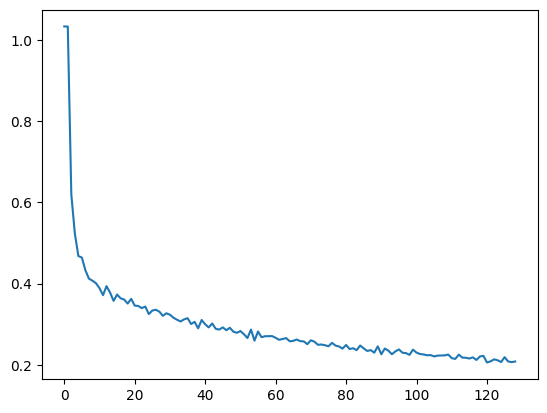

Loaded best model from ./models/bilstm_crf.model
Final evaluation:
Train: new_F: 0.7176 best_F: -1.0000

Train Results by Entity Type:
Entity    Precision Recall    F1-score  
----------------------------------------
B-Area    0.88    0.83    0.86
B-Exp     0.90    0.91    0.90
B-Features0.73    0.56    0.63
B-HackOrg 0.76    0.71    0.73
B-Idus    0.73    0.60    0.66
B-OffAct  0.72    0.77    0.75
B-Org     0.69    0.70    0.70
B-Purp    0.69    0.43    0.53
B-SamFile 0.68    0.62    0.65
B-SecTeam 0.85    0.79    0.82
B-Time    0.89    0.91    0.90
B-Tool    0.69    0.56    0.62
B-Way     0.77    0.56    0.65
E-Area    0.89    0.84    0.86
E-Exp     0.92    0.92    0.92
E-Features0.72    0.56    0.63
E-HackOrg 0.75    0.71    0.73
E-Idus    0.72    0.59    0.65
E-OffAct  0.74    0.79    0.77
E-Org     0.73    0.73    0.73
E-Purp    0.68    0.42    0.52
E-SamFile 0.69    0.63    0.66
E-SecTeam 0.82    0.76    0.79
E-Time    0.87    0.89    0.88
E-Tool    0.69    0.56    0.61
E-Way   

In [15]:
# Main execution code
if __name__ == "__main__":
    # Paths and parameters configuration
    train_path = "./data/train.txt"
    val_path = "./data/valid.txt"
    test_path = "./data/test.txt"
    output_path = "./data/preprocessed_data.pkl"
    model_path = "./models/bilstm_crf.model"
    embedding_path = None  # Optional: path to word embeddings file
    model_dir = os.path.dirname(model_path)
    if model_dir and not os.path.exists(model_dir):
        os.makedirs(model_dir, exist_ok=True)
        print(f"Created model directory: {model_dir}")
    # Preprocessing parameters
    word_dim = 100
    tag_scheme = 'BIOES'
    lower = True
    zeros = True
    
    # Model parameters
    char_dim = 25
    char_lstm_dim = 25
    char_out_dimension = 25
    word_lstm_dim = 200
    dropout = 0.5
    use_crf = True
    char_mode = 'CNN'
    
    # Training parameters
    learning_rate = 0.015
    momentum = 0.9
    num_epochs = 50
    decay_rate = 0.05
    gradient_clip = 5.0
    
    # Control flags
    reload_model = False
    use_gpu = torch.cuda.is_available()
    
    # First, preprocess the data
    mappings = preprocess_data(
        train_path=train_path,
        val_path=val_path,
        test_path=test_path,
        output_path=output_path,
        embedding_path=embedding_path,
        word_dim=word_dim,
        tag_scheme=tag_scheme,
        lower=lower,
        zeros=zeros
    )
    
    # Extract data components from mappings
    word_to_id = mappings['word_to_id']
    tag_to_id = mappings['tag_to_id']
    char_to_id = mappings['char_to_id']
    train_data = mappings['train_data']
    val_data = mappings['val_data']
    test_data = mappings['test_data']
    word_embeds = mappings['word_embeds']
    id_to_word = mappings['id_to_word']
    id_to_tag = mappings['id_to_tag']
    id_to_char = mappings['id_to_char']
    
    # Create the model
    model = BiLSTM_CRF(
        vocab_size=len(word_to_id),
        tag_to_ix=tag_to_id,
        embedding_dim=word_dim,
        hidden_dim=word_lstm_dim,
        char_to_ix=char_to_id,
        pre_word_embeds=word_embeds,
        char_out_dimension=char_out_dimension,
        char_embedding_dim=char_dim,
        dropout=dropout,
        char_lstm_dim=char_lstm_dim,
        use_gpu=use_gpu,
        use_crf=use_crf,
        char_mode=char_mode
    )
    
    print("Model Initialized!")
    
    # Reload a saved model if requested
    if reload_model:
        if not os.path.exists(model_path):
            print("Downloading pre-trained model")
            model_url = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/trained-model-cpu"
            urllib.request.urlretrieve(model_url, model_path)
        model.load_state_dict(torch.load(model_path))
        print(f"Model reloaded from: {model_path}")
    
    # Move model to GPU if available
    if use_gpu:
        model.cuda()
    
    # Initialize optimizer - SGD with momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    # Training process variables
    losses = []  # List to store all losses
    loss = 0.0   # Loss initialization
    best_dev_F = -1.0    # Best F-1 score on dev set
    best_test_F = -1.0   # Best F-1 score on test set
    best_train_F = -1.0  # Best F-1 score on train set
    all_F = [[0, 0, 0]]  # List storing all F-1 scores
    eval_every = len(train_data)  # Evaluate after this many iterations
    plot_every = 2000    # Store loss after this many iterations
    count = 0            # Counts the number of iterations
    
    # Only train if not reloading a pre-trained model
    if not reload_model:
        tr = time.time()
        model.train(True)
        
        for epoch in range(1, num_epochs):
            for i, index in enumerate(np.random.permutation(len(train_data))):
                count += 1
                data = train_data[index]
                
                # Gradient updates for each data entry
                model.zero_grad()
                
                sentence_in = data['words']
                sentence_in = Variable(torch.LongTensor(sentence_in))
                tags = data['tags']
                chars2 = data['chars']
                
                if char_mode == 'LSTM':
                    chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
                    d = {}
                    for i, ci in enumerate(chars2):
                        for j, cj in enumerate(chars2_sorted):
                            if ci == cj and not j in d and not i in d.values():
                                d[j] = i
                                continue
                    chars2_length = [len(c) for c in chars2_sorted]
                    char_maxl = max(chars2_length)
                    chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
                    for i, c in enumerate(chars2_sorted):
                        chars2_mask[i, :chars2_length[i]] = c
                    chars2_mask = Variable(torch.LongTensor(chars2_mask))
                
                if char_mode == 'CNN':
                    d = {}
                    
                    # Padding each word to max word size of that sentence
                    chars2_length = [len(c) for c in chars2]
                    char_maxl = max(chars2_length)
                    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
                    for i, c in enumerate(chars2):
                        chars2_mask[i, :chars2_length[i]] = c
                    chars2_mask = Variable(torch.LongTensor(chars2_mask))
                
                targets = torch.LongTensor(tags)
                
                # Calculate negative log-likelihood for predicted tags
                if use_gpu:
                    neg_log_likelihood = model.neg_log_likelihood(
                        sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d
                    )
                else:
                    neg_log_likelihood = model.neg_log_likelihood(
                        sentence_in, targets, chars2_mask, chars2_length, d
                    )
                
                loss += neg_log_likelihood.item() / len(data['words'])
                neg_log_likelihood.backward()
                
                # Use gradient clipping to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                optimizer.step()
                
                # Storing loss
                if count % plot_every == 0:
                    loss /= plot_every
                    print(f"{count}: {loss}")
                    if not losses:
                        losses.append(loss)
                    losses.append(loss)
                    loss = 0.0
                
                # Evaluating on Train, Test, Dev Sets
                if (count % eval_every == 0 and count > (eval_every * 20)) or \
                   (count % (eval_every*4) == 0 and count < (eval_every * 20)):
                    model.train(False)
                    best_train_F, new_train_F, _ = evaluating(
                        model, train_data, best_train_F, "Train", char_mode, use_gpu, tag_to_id
                    )
                    best_dev_F, new_dev_F, save = evaluating(
                        model, val_data, best_dev_F, "Dev", char_mode, use_gpu, tag_to_id
                    )
                    
                    if save:
                        print(f"Saving Model to {model_path}")
                        torch.save(model.state_dict(), model_path)
                        
                    best_test_F, new_test_F, _ = evaluating(
                        model, test_data, best_test_F, "Test", char_mode, use_gpu, tag_to_id
                    )
                    
                    all_F.append([new_train_F, new_dev_F, new_test_F])
                    model.train(True)
                
                # Learning rate decay
                if count % len(train_data) == 0:
                    adjust_learning_rate(
                        optimizer, 
                        lr=learning_rate/(1+decay_rate*count/len(train_data))
                    )
        
        print(f"Training completed in {time.time() - tr} seconds")
        plt.plot(losses)
        plt.show()
    
    # Always reload the best model saved from training
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded best model from {model_path}")
    
    # Final evaluation
    print("Final evaluation:")
    _, train_F, _ = evaluating(model, train_data, -1.0, "Train", char_mode, use_gpu, tag_to_id)
    _, dev_F, _ = evaluating(model, val_data, -1.0, "Dev", char_mode, use_gpu, tag_to_id)
    _, test_F, _ = evaluating(model, test_data, -1.0, "Test", char_mode, use_gpu, tag_to_id)
    
    print(f"Final F1 scores - Train: {train_F}, Dev: {dev_F}, Test: {test_F}")